# 前処理

In [0]:
#installing dependencies
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null

!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:
!pip install keras-rl

# PendulumProcessor と DQN Agent

In [0]:
import gym

import pickle
import os
import numpy as np
import random

import tensorflow as tf

from keras.optimizers import Adam
from keras.models import Model
from keras.layers import *
from keras import backend as K

import rl.core

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

class PendulumProcessorForDQN(rl.core.Processor):
    def __init__(self, enable_image=False, reshape_size=(84, 84)):
        self.shape = reshape_size
        self.enable_image = enable_image
    
    def process_observation(self, observation):
        if not self.enable_image:
            return observation
        img = self._get_rgb_state(observation)
        img = Image.fromarray(img)
        img = img.resize(self.shape).convert('L')  # resize and convert to grayscale
        return np.array(img) / 255

    def process_action(self, action):
        ACT_ID_TO_VALUE = {
            0: [-2.0], 
            1: [-1.0], 
            2: [0.0], 
            3: [+1.0],
            4: [+2.0],
        }
        return ACT_ID_TO_VALUE[action]

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

    # 状態（x,y座標）から対応画像を描画する関数
    def _get_rgb_state(self, state):
        img_size = 84

        h_size = img_size/2.0

        img = Image.new("RGB", (img_size, img_size), (255, 255, 255))
        dr = ImageDraw.Draw(img)

        # 棒の長さ
        l = img_size/4.0 * 3.0/ 2.0

        # 棒のラインの描写
        dr.line(((h_size - l * state[1], h_size - l * state[0]), (h_size, h_size)), (0, 0, 0), 1)

        # 棒の中心の円を描写（それっぽくしてみた）
        buff = img_size/32.0
        dr.ellipse(((h_size - buff, h_size - buff), (h_size + buff, h_size + buff)), 
                   outline=(0, 0, 0), fill=(255, 0, 0))

        # 画像の一次元化（GrayScale化）とarrayへの変換
        pilImg = img.convert("L")
        img_arr = np.asarray(pilImg)

        # 画像の規格化
        img_arr = img_arr/255.0

        return img_arr

class DQNAgent(rl.core.Agent):
    def __init__(self, 
        input_shape, 
        enable_image_layer,
        nb_actions,
        window_length=4,          # 入力フレーム数
        memory_capacity=1000000,  # 確保するメモリーサイズ
        nb_steps_warmup=50000,    # 初期のメモリー確保用step数(学習しない)
        target_model_update=500,  # target networkのupdate間隔
        action_interval=4,  # アクションを実行する間隔
        train_interval=4,   # 学習間隔
        batch_size=32,      # batch_size
        gamma=0.99,        # Q学習の割引率
        initial_epsilon=1.0,  # ϵ-greedy法の初期値
        final_epsilon=0.1,    # ϵ-greedy法の最終値
        exploration_steps=1000000,  # ϵ-greedy法の減少step数
        **kwargs):
        super(DQNAgent, self).__init__(**kwargs)
        self.compiled = False

        self.input_shape = input_shape
        self.enable_image_layer = enable_image_layer
        self.nb_actions = nb_actions
        self.window_length = window_length
        self.nb_steps_warmup = nb_steps_warmup
        self.target_model_update = target_model_update
        self.action_interval = action_interval
        self.train_interval = train_interval
        self.gamma = gamma
        self.batch_size = batch_size

        self.initial_epsilon = initial_epsilon  
        self.epsilon_step = (initial_epsilon - final_epsilon) / exploration_steps
        self.final_epsilon = final_epsilon

        self.memory = ReplayMemory(capacity=memory_capacity)

        self.model = self.build_network()         # Q network
        self.target_model = self.build_network()  # target network
        
        assert memory_capacity > self.batch_size, "Memory capacity is small.(Larger than batch size)"
        assert self.nb_steps_warmup > self.batch_size, "Warmup steps is few.(Larger than batch size)"
        
    def reset_states(self):
        self.recent_observations = [np.zeros(self.input_shape) for _ in range(self.window_length+1)]
        self.recent_action = 0
        self.recent_reward = 0
        self.repeated_action = 0

    def compile(self, optimizer=None, metrics=[]):
        # target networkは更新がないので optimizerとlossは何でもいい
        self.target_model.compile(optimizer='sgd', loss='mse')

        def clipped_error_loss(y_true, y_pred):
            err = y_true - y_pred  # エラー
            L2 = 0.5 * K.square(err)
            L1 = K.abs(err) - 0.5

            # エラーが[-1,1]区間ならL2、それ以外ならL1を選択する。
            loss = tf.where((K.abs(err) < 1.0), L2, L1)   # Keras does not cover where function in tensorflow :-(
            return K.mean(loss)
        self.model.compile(loss=clipped_error_loss, optimizer=optimizer, metrics=metrics)

        self.compiled = True

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    def save_weights(self, filepath, overwrite=False):
        self.model.save_weights(filepath, overwrite=overwrite)

    def forward(self, observation):
        # windowサイズ分observationを保存する
        self.recent_observations.append(observation)  # 最後に追加
        self.recent_observations.pop(0)  # 先頭を削除

        # 学習(次の状態が欲しいのでforwardで学習)
        self.forward_train()

        # フレームスキップ(action_interval毎に行動を選択する)
        action = self.repeated_action
        if self.step % self.action_interval == 0:
            if self.training:
                
                # ϵ をstepで減少。
                epsilon = self.initial_epsilon - self.step*self.epsilon_step
                if epsilon < self.final_epsilon:
                    epsilon = self.final_epsilon
                
                # ϵ-greedy法
                if epsilon > np.random.uniform(0, 1):
                    # ランダム
                    action = np.random.randint(0, self.nb_actions)
                else:
                    # 現在の状態を取得し、最大Q値から行動を取得。
                    state0 = self.recent_observations[1:]
                    q_values = self.model.predict(np.asarray([state0]), batch_size=1)[0]
                    action = np.argmax(q_values)
            else:
                # 現在の状態を取得し、最大Q値から行動を取得。
                state0 = self.recent_observations[1:]
                q_values = self.model.predict(np.asarray([state0]), batch_size=1)[0]
                action = np.argmax(q_values)

            self.repeated_action = action
        
        self.recent_action = action
        return action

    # 長いので関数に
    def forward_train(self):
        if not self.training:
            return

        self.memory.add((self.recent_observations[:self.window_length], self.recent_action, self.recent_reward, self.recent_observations[1:]))

        # ReplayMemory確保のため一定期間学習しない。
        if self.step <= self.nb_steps_warmup:
            return

        # 学習の更新間隔
        if self.step % self.train_interval != 0:
            return

        batchs = self.memory.sample(self.batch_size)
        state0_batch = []
        action_batch = []
        reward_batch = []
        state1_batch = []
        for batch in batchs:
            state0_batch.append(batch[0])
            action_batch.append(batch[1])
            reward_batch.append(batch[2])
            state1_batch.append(batch[3])

        # 更新用に現在のQネットワークを出力(Q network)
        outputs = self.model.predict(np.asarray(state0_batch), self.batch_size)

        # 次の状態のQ値を取得(target_network)
        target_qvals = self.target_model.predict(np.asarray(state1_batch), self.batch_size)

        # Q学習、Q(St,At)=Q(St,At)+α(r+γmax(St+1,At+1)-Q(St,At))
        for i in range(self.batch_size):
            maxq = np.max(target_qvals[i])
            td_error = reward_batch[i] + self.gamma * maxq
            outputs[i][action_batch[i]] = td_error

        # 学習
        self.model.train_on_batch(np.asarray(state0_batch), np.asarray(outputs))


    def backward(self, reward, terminal):
        # 一定間隔でtarget modelに重さをコピー
        if self.step % self.target_model_update == 0:
            self.target_model.set_weights(self.model.get_weights())
        
        self.recent_reward = reward
        return []

    @property
    def layers(self):
        return self.model.layers[:]

    # NNモデルの作成
    def build_network(self):

        # 入力層(window_length, width, height)
        c = input_ = Input(shape=(self.window_length,) + self.input_shape)

        if self.enable_image_layer:
            c = Permute((2, 3, 1))(c)  # (window,w,h) -> (w,h,window)

            c = Conv2D(32, (8, 8), strides=(4, 4), padding="same")(c)
            c = Activation("relu")(c)
            c = Conv2D(64, (4, 4), strides=(2, 2), padding="same")(c)
            c = Activation("relu")(c)
            c = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(c)
            c = Activation("relu")(c)
        c = Flatten()(c)

        c = Dense(512, activation="relu")(c)

        c = Dense(self.nb_actions, activation="linear")(c)  # 出力層

        return Model(input_, c)


class ReplayMemory():
    def __init__(self, capacity):
        self.capacity= capacity
        self.index = 0
        self.memory = []

    def add(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.index] = experience
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
      


Using TensorFlow backend.


# 学習（数値入力）

In [0]:
env = gym.make("Pendulum-v0")

nb_actions = 5  # PendulumProcessorで5個と定義しているので5

processor = PendulumProcessorForDQN(enable_image=False)

# 引数が多いので辞書で定義して渡しています。
args={
    "input_shape": env.observation_space.shape, 
    "enable_image_layer": False, 
    "nb_actions": nb_actions, 
    "window_length": 1,         # 入力フレーム数
    "memory_capacity": 100000,  # 確保するメモリーサイズ
    "nb_steps_warmup": 200,     # 初期のメモリー確保用step数(学習しない)
    "target_model_update": 100, # target networkのupdate間隔
    "action_interval": 1,  # アクションを実行する間隔
    "train_interval": 1,   # 学習する間隔
    "batch_size": 64,   # batch_size
    "gamma": 0.99,     # Q学習の割引率
    "initial_epsilon": 1.0,  # ϵ-greedy法の初期値
    "final_epsilon": 0.1,    # ϵ-greedy法の最終値
    "exploration_steps": 5000,  # ϵ-greedy法の減少step数
    "processor": processor,
}
agent = DQNAgent(**args)
agent.compile(optimizer=Adam())





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# 訓練
history = agent.fit(env, nb_steps=50_000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)






   59/10000 [..............................] - ETA: 3:12 - reward: -1.0000   WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.


10000/10000 [==============================] - 60s 6ms/step - reward: -0.6292
50 episodes - episode_reward: -125.831 [-200.000, -22.149]

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 64s 6ms/step - reward: -0.1567
50 episodes - episode_reward: -31.346 [-74.352, -1.572]

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 63s 6ms/step - reward: -0.1632
50 episodes - episode_reward: -32.645 [-65.129, -0.674]

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 62s 6ms/step - reward: -0.1453
50 episodes - episode_reward: -29.060 [-56.932, -0.985]

Interval 5 (40000 st

# 結果（数値入力）

In [0]:
import rl.callbacks
import matplotlib.pyplot as plt
import matplotlib.animation
import time
class ViewLogger(rl.callbacks.Callback):
    def __init__(self):
        self.frames = []

    # Callback から継承しています。
    def on_action_end(self, action, logs):
        self.frames.append(self.env.render(mode='rgb_array'))
    
    # 表示用
    def view(self, interval=5, start_frame=0, end_frame=0):
        assert start_frame<len(self.frames)
        if end_frame == 0:
          end_frame = len(self.frames)
        elif end_frame > len(self.frames):
            end_frame = len(self.frames)
        self.start_frame = start_frame
        self.t0 = time.time()
        
        # 表示サイズをここで指定しています。
        plt.figure(figsize=(2.5,2.5), dpi = 200)

        self.patch = plt.imshow(self.frames[0])
        plt.axis('off')
        
        ani = matplotlib.animation.FuncAnimation(plt.gcf(), self._plot, frames=end_frame - start_frame, interval=interval)
        return ani.to_jshtml()
      
    def _plot(self, frame):
        if frame % 200 == 0:
            print("{}f {}m".format(frame, (time.time()-self.t0)/60))
        self.patch.set_data(self.frames[frame + self.start_frame])

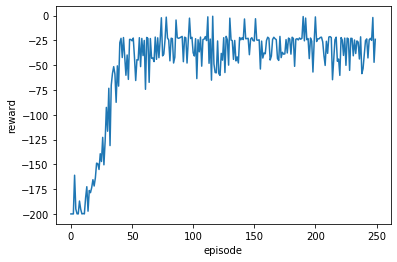

In [0]:
import matplotlib.pyplot as plt

# 結果を表示
plt.subplot(1,1,1)
plt.plot(history.history["episode_reward"])
plt.xlabel("episode")
plt.ylabel("reward")

plt.show()

Testing for 5 episodes ...
Episode 1: reward: -37.253, steps: 200
Episode 2: reward: -37.159, steps: 200
Episode 3: reward: -36.105, steps: 200
Episode 4: reward: -20.937, steps: 200
Episode 5: reward: -22.829, steps: 200
0f 0.00033334891001383465m
0f 0.0003876209259033203m
200f 0.15930467049280803m
400f 0.31803136666615806m
600f 0.4786940654118856m
800f 0.6373112797737122m


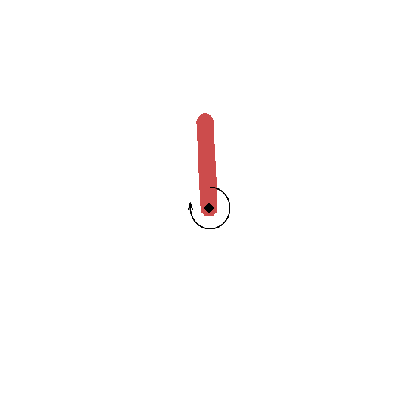

In [0]:
view = ViewLogger()
agent.test(env, nb_episodes=5, visualize=False, callbacks=[view])

from IPython.display import HTML
HTML(view.view(interval=10, start_frame=0, end_frame=0))

# 学習(画像入力)

In [0]:
env = gym.make("Pendulum-v0")

nb_actions = 5  # PendulumProcessorで5個と定義しているので5

processor = PendulumProcessorForDQN(enable_image=True, reshape_size=(84, 84))

# 引数が多いので辞書で定義して渡しています。
args={
    "input_shape": (84, 84), 
    "enable_image_layer": True, 
    "nb_actions": nb_actions, 
    "window_length": 3,         # 入力フレーム数
    "memory_capacity": 100000,  # 確保するメモリーサイズ
    "nb_steps_warmup": 200,     # 初期のメモリー確保用step数(学習しない)
    "target_model_update": 100, # target networkのupdate間隔
    "action_interval": 1,  # アクションを実行する間隔
    "train_interval": 1,   # 学習する間隔
    "batch_size": 32,   # batch_size
    "gamma": 0.99,     # Q学習の割引率
    "initial_epsilon": 1.0,  # ϵ-greedy法の初期値
    "final_epsilon": 0.1,    # ϵ-greedy法の最終値
    "exploration_steps": 50000,  # ϵ-greedy法の減少step数
    "processor": processor,
}
agent = DQNAgent(**args)
agent.compile(optimizer=Adam())

In [0]:
# 訓練
history = agent.fit(env, nb_steps=100_000, visualize=False, verbose=1)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 222s 22ms/step - reward: -0.9508
50 episodes - episode_reward: -190.152 [-200.000, -165.397]

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 225s 22ms/step - reward: -0.9397
50 episodes - episode_reward: -187.938 [-200.000, -144.477]

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 231s 23ms/step - reward: -0.9686
50 episodes - episode_reward: -193.722 [-200.000, -157.971]

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 237s 24ms/step - reward: -0.9367
50 episodes - episode_reward: -187.346 [-200.000, -146.935]

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 234s 23ms/step - reward: -0.9750
50 episodes - episode_reward: -195.005 [-200.000, -171.294]

Interval 6 (50000 steps performed)
10000/10000 [==============================] - 238s 24ms/st

# 結果(画像入力)

In [0]:
import matplotlib.pyplot as plt

# 結果を表示
plt.subplot(1,1,1)
plt.plot(history.history["episode_reward"])
plt.xlabel("episode")
plt.ylabel("reward")

plt.show()

In [0]:
view = ViewLogger()
agent.test(env, nb_episodes=5, visualize=False, callbacks=[view])

from IPython.display import HTML
HTML(view.view(interval=10, start_frame=0, end_frame=0))